## Car Class


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

class Car(object):
    def __init__(self, x=0.0, y=0.0, orientation=0.0, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = x
        self.y = y
        self.orientation = orientation
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, speed, delta_t=1.0, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if speed < 0.0:
            speed = 0.0

        # apply noise
        actual_steering = random.gauss(steering, self.steering_noise)
        actual_distance = random.gauss(speed*delta_t, self.distance_noise) 

        # apply steering drift
        actual_steering += self.steering_drift

        # Execute motion
        turn_angle = np.tan(actual_steering) * actual_distance / self.length

        if abs(turn_angle) < tolerance:
            # approximate by straight line motion
            self.x += actual_distance * np.cos(self.orientation)
            self.y += actual_distance * np.sin(self.orientation)
            self.orientation = (self.orientation + turn_angle) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = actual_distance / turn_angle
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn_angle) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)  

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)


## Implement P Controller
The Proportional term determines how hard the car will turn towards its desired trajectory. The larger the proportional term, the more frequently the car will oscillate about its desired trajectory. 

Implement the P controller below

$steer(t) = - K_p * e_p(t)$

where $steer$ is the steering angle of the car in radians, $K_p$ is the proportional constant, and $e_p$ is the cross-track error (error in y position)

Note: To start off with, you shouldn't be changing any parameters other than kp when running the proportional controller

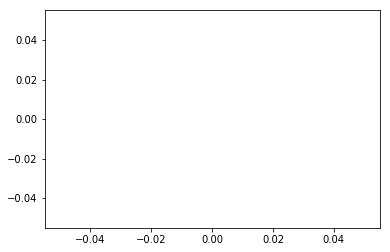

In [15]:
car = Car(x=0, y=1, orientation=0)

def run_pcontroller(car, kp, initial_step=2.0, step_size=2.0, num_steps=2, n=100, speed=1.0):
    """
    Performs n actuations using proprotional control
    
    Returns the list of actual x positions, actual y positions, and the desired y positions
    Because we are not performing longitudinal control, there are no desired x positions
    
    Parameters
    -----------
    
    car : Car object 
        see car class defined above
    kp : float
        proportional constant 
    initial_step : float
        Initial desired y position of the car
    step_size : float
        Amount to change desired y position
    num_step : int
        The number of desired y positions
    n : int
        Number of actuations to perform
    speed : float
        speed of the car
    
    
    """
    
    x_trajectory = []
    y_trajectory = []
    desired_y_trajectory = []

    desired_y = initial_step
    prev_ep = car.y - initial_step
    ei = 0
    for i in range(n):
        if (i%(n//num_steps) == 0 and i > 0):
          desired_y += step_size
        #TODO: Your code here
        
    return x_trajectory, y_trajectory, desired_y_trajectory

#TODO: Play with this value
kp = 1.0

x_trajectory, y_trajectory, desired_y_trajectory = run_pcontroller(car, kp=kp)

plt.plot(x_trajectory, y_trajectory, 'g', label='PID controller')
plt.plot(x_trajectory, desired_y_trajectory, 'r', label='reference')
plt.show()

## Implement PD Controller
The Derivative term determines how much the car will resist changes in its position. The larger the derivative term, the less the car will oscillate. Make the derivative term too big, and the car will approach its desired y position too slowly.

In this exercise, we will just be using differences instead of actual derivatives to implement the PD controller. 

Implement the PD controller below

$steer(t) = - K_p * e_p(t) - K_d * e_d(t)$

$e_d(t) = e_{p}(t) - e_{p}(t-1)$

where $steer$ is the steering angle of the car in radians, $K_p$ is the proportional constant, $e_p$ is the cross-track error (error in y position), $K_d$ is the derivative constant, and $e_d$ is the derivative (technically difference) error. 

Note: To start off with, you shouldn't be changing any parameters other than kp and kd when running the controller

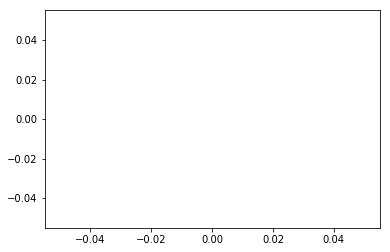

In [16]:
car = Car(x=0, y=1, orientation=0)

def run_pdcontroller(car, kp, kd, initial_step=2.0, step_size=2.0, num_steps=2, n=100, speed=1.0):
    """
    Performs n actuations using proprotional derivative control assuming car moves at constant speed
    
    Returns the list of actual x positions, actual y positions, and the desired y positions
    Because we are not performing longitudinal control, there are no desired x positions
    
    Parameters
    ----------
    
    car : Car object 
        see car class defined above
    kp : float
        proportional constant 
    kd: float
        derivative constant
    initial_step : float
        Initial desired y position of the car
    step_size : float
        Amount to change desired y position
    num_step : int
        The number of different desired y positions
    n : int
        Number of actuations to perform
    speed : float
        speed of the car
        
    Returns
    -------
    
    x_trajectory : List of floats
        The actual x positions of the car over time
    y_trajectory : List of floats
        The actual y positions of the car over time
    desired_y_trajectory: List of floats
        The desired y positions of the car over time
    
    """
    
    x_trajectory = []
    y_trajectory = []
    desired_y_trajectory = []
    
    desired_y = initial_step
    prev_ep = car.y - desired_y # previous proportional error
    for i in range(n):
        if (i%(n//num_steps) == 0 and i > 0):
          desired_y += step_size
        #TODO: Your code here
        
    return x_trajectory, y_trajectory, desired_y_trajectory

#TODO: Play with this value
kp = 1.0
kd = 0.0
x_trajectory, y_trajectory, desired_y_trajectory = run_pdcontroller(car, kp=kp, kd=kd)

plt.plot(x_trajectory, y_trajectory, 'g', label='PID controller')
plt.plot(x_trajectory, desired_y_trajectory, 'r', label='reference')
plt.show()

## Implement PID Controller
The Integral term offsets any bias that is causing the car to accumulate a consistent offset, such as wind that is consitently pushing the car to the left. 

In this exercise, we will model an integral as a basic summation. 

Implement the PD controller below

$steer(t) = - K_p * e_p(t) - K_d * e_d(t) - K_i * e_i(t)$

$e_d(t) = e_{p}(t) - e_{p}(t-1)$

$e_i(t) = \displaystyle\sum_{t}e_p(t)$

where $steer$ is the steering angle of the car in radians, $K_p$ is the proportional constant, $e_p$ is the cross-track error (error in y position), $K_d$ is the derivative constant, $e_d$ is the derivative (technically difference) error, $K_i$ is the integral constant, and $e_i$ is the integral error. 

Note: To start off with, you shouldn't be changing any parameters other than kp, kd, and ki when running the controller

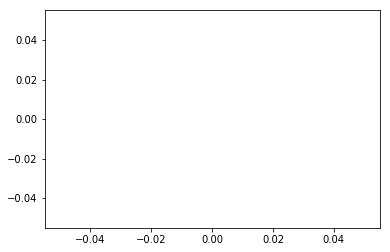

In [17]:
car = Car(x=0, y=1, orientation=0)

#TODO: When you've implemented the entire PID controller below, try adding some noise and drift
car.set_noise(0.0,0.0)
car.set_steering_drift(0.0)

def run_pidcontroller(car, kp, kd, ki, initial_step=2.0, step_size=2.0, num_steps=2, n=100, speed=1.0):
    """
    Performs n actuations using proprotional derivative integral control assuming car moves at constant speed
    
    Returns the list of actual x positions, actual y positions, and the desired y positions
    Because we are not performing longitudinal control, there are no desired x positions
    
    Parameters
    ----------
    
    car : Car object 
        see car class defined above
    kp : float
        proportional constant 
    kd: float
        derivative constant
    initial_step : float
        Initial desired y position of the car
    step_size : float
        Amount to change desired y position
    num_step : int
        The number of different desired y positions
    n : int
        Number of actuations to perform
    speed : float
        speed of the car
        
    Returns
    -------
    
    x_trajectory : List of floats
        The actual x positions of the car over time
    y_trajectory : List of floats
        The actual y positions of the car over time
    desired_y_trajectory: List of floats
        The desired y positions of the car over time
    
    """
    
    x_trajectory = []
    y_trajectory = []
    desired_y_trajectory = []
    
    desired_y = initial_step
    prev_ep = car.y - desired_y # previous proportional error
    ei = 0 # initial integral error
    for i in range(n):
        if (i%(n//num_steps) == 0 and i > 0):
          desired_y += step_size
        #TODO: Your code here
        
    return x_trajectory, y_trajectory, desired_y_trajectory

#TODO: Play with these values
kp = 1.0
kd = 0.0
ki = 0.0
x_trajectory, y_trajectory, desired_y_trajectory = run_pidcontroller(car, kp=kp, kd=kd, ki=ki)

plt.plot(x_trajectory, y_trajectory, 'g', label='PID controller')
plt.plot(x_trajectory, desired_y_trajectory, 'r', label='reference')
plt.show()

## Let's Twiddle: PID Auto-Tuning Algorithm

Twiddle is an algorithm that automatically tunes the parameters of your pid controller up and down similar to how a human would twiddle the parameters to bring the average error down. 

The general idea is to loop through all of your parameters, trying small changes in them, until changing them by small amounts no longer causes a decrease in your average error. 

First you try increasing by some change, like 0.2. See if that decreases the error. If it does, increase the change by a small amount, like 10% and continue. If it doesn't, try decreasing the parameter by 0.2. If this decreases your error, then you once again increase the change by a small amount, like 10% and continue. If neither increasing nor decreasing the parameter causes a decrease in the average error, then make your change smaller by a small amount, like 10%, and try twiddling the parameter again in the next iteration.

If that is confusing, try reading the psuedo code below:

```
# Define your initial parameters kp, kd, ki to all zeroes in some array
p = [0.0, 0.0, 0.0]
# Define your initial changes in parameters that you wish to try to see if these changes decrease your error
dp = [0.2, 0.2, 0.2]
# run one iteration of the pid controller to get the average error
best_err = run()

while (sum of differences in parameters < some tolerance):
   print(best_err) # for debugging; make sure your error is converging and not timing out
   for i in range(len(p)):
       p[i] += dp[i]
       err = run()
       if (err < best_err):
           best_err = err
           dp[i] *= 1.1
       else:
           p[i] -= 2*dp[i]
           err = run()
           if (err < best_err):
               best_err = err
               dp[i] *= 1.1
           else:
               p[i] += dp[i]
               dp[i] *= 0.9
```

Now code it up. 

You can also try playing with the ```run()``` function. Try using a different type of error function. Instead of using absolute value, try using squared error, or any other type of error you can think of that might be helpful.


Final twiddle error = 79.97098432720605
params:  [0.0, 0.0, 0.0]


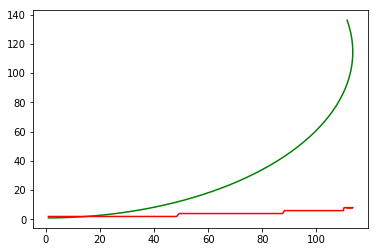

In [152]:
def make_car():
    """
    Resets the car back to the initial position and drift.
    You'll want to call this every time after you run your pid controller.
    """
    car = Car(x=0, y=1, orientation=0)
    car.set_steering_drift(10 / 180 * np.pi)
    return car

desired_y_trajectory = []
# NOTE: We use params instead of kp, kd, ki
def run(car, params, initial_step=2.0, step_size=2.0, num_steps=2, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    err = 0
    prev_cte = car.y
    int_cte = 0
    desired_y = initial_step
    global desired_y_trajectory
    desired_y_trajectory = []
    for i in range(2*n):
        if (i%(n//num_steps)==0 and i > 0):
          desired_y += step_size
        desired_y_trajectory.append(desired_y)
        cte = car.y - desired_y
        diff_cte = cte - prev_cte
        int_cte += cte
        prev_cte = cte
        steer = -params[0] * cte - params[1] * diff_cte - params[2] * int_cte
        car.move(steer, speed)
        x_trajectory.append(car.x)
        y_trajectory.append(car.y)
        if i >= n:
            err += abs(cte)
    return x_trajectory, y_trajectory, err / n


# Make this tolerance bigger if you are timing out!
def twiddle(tol=0.001):
    # Don't forget to call `make_car` before every call of `run`!
    car = make_car()
    p = [0.0, 0.0, 0.0]
    dp = [0.2, 0.2, 0.2]
    x_trajectory, y_trajectory, best_err = run(car, p)
    # TODO: twiddle loop here

    return p, best_err


params, err = twiddle()

# Below are some values I got from different variations of twiddle and some slight manual tuning
#params = [1.594227820766397, 9.459256396144342, 0.025210084776278136]
#params = [3.2908954769482617, 18.752138762789, 0.021340576168845212]

print("Final twiddle error = {}".format(err))
car = make_car()
x_trajectory, y_trajectory, err = run(car, params)
print("params: ", params)
n = len(x_trajectory)

plt.plot(x_trajectory, y_trajectory, 'g', label='PID controller')
plt.plot(x_trajectory, desired_y_trajectory, 'r', label='reference')
plt.show()